Luciano Pinheiro Batista 173096

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision = 4)

def Conta_Classes(Label_Set):
    P = np.sum(np.equal(Label_Set, 1))
    N = np.sum(np.equal(Label_Set, 0))
    return np.array([P/(P+N), N/(P+N)])

Train_Images = np.load('train_images.npy')/255
Train_Labels = np.load('train_labels.npy')

Val_Images = np.load('val_images.npy')/255
Val_Labels = np.load('val_labels.npy')

Test_Images = np.load('test_images.npy')/255
Test_Labels = np.load('test_labels.npy')




#Conta_Classes(Train_Labels)
#Conta_Classes(Val_Labels)
#Conta_Classes(Test_Labels)

O balanço entre classes obtido pela função *Conta_Classes* foi igual para os três conjuntos - treino, validação e teste:

- Positivo: **73.08%**
- Negativo: **26.92%**

Há uma predominância da classe positiva, aproximadamente 3 em cada 4 amostras pertencem a esta classe.

In [2]:
#Extração de atributos a partir das imagens

def Atributos(Image_Set, Dim_Image):
    Atributos_Empilhados = np.empty((0, Dim_Image ** 2))
    for Image in Image_Set:
        Vetor_Linhas = np.empty(0)
        for Linha in Image:
            Vetor_Linhas = np.hstack((Vetor_Linhas, Linha))
        Atributos_Empilhados = np.vstack((Atributos_Empilhados, Vetor_Linhas)) 
    Fi = np.hstack((np.ones((len(Atributos_Empilhados), 1)), Atributos_Empilhados))
    return Fi
    

Dim_Image = len(Train_Images[0])
Fi_Train = Atributos(Train_Images, Dim_Image)
Fi_Val   = Atributos(Val_Images, Dim_Image)
Fi_Test  = Atributos(Test_Images, Dim_Image)




A função Atributos foi utilizada para armazenar todos os pixels de uma imagem do conjunto em um vetor de tamanho $28^2 = 784$. Os atributos de cada imagem do conjunto foram empilhados e a matriz Fi de cada conjunto - treino, validação e teste - foi gerada.

In [32]:
#Treinamento
def Calcula_Grad(Fi_Train, w, Train_Labels):
    E = np.empty((0, 1))
    for i in range(len(Fi_Train)):
        Label_Calc = 1 / (1 + np.exp(-(np.dot(Fi_Train[i], w))))
        Erro = Train_Labels[i][0] - Label_Calc
        E = np.vstack((E, Erro))
    Grad = - 1/len(Fi_Train) * (np.matmul(E.T, Fi_Train))
    return Grad[0]




w = np.random.rand(len(Fi_Train[0]))

Alfa = .01
for i in range(10000):
    w  = w - Alfa * Calcula_Grad(Fi_Train, w, Train_Labels)
        


Para o treinamento foi utilizado o método do gradiente descendente em batelada, implementado na função *Calcula_Grad*. A escolha é coerente com base no tamanho do conjunto de dados deste problema. A rotina realiza uma função logística, com base nos atributos e vetor de parâmetros. O passo $\alpha$ e o número de épocas de treinamento foram ajustados com base nos melhores valores de Acurácia Balanceada e Precisão alcançados na etapa de validação. Isto foi obtido com $\alpha = .01$ e $10000$ épocas. Além disso, foi observado que o valor inicial do vetor de parâmetros também altera fundamentalmente os resultados. Resultados melhores foram obtidos com todos os parâmetros iniciando com valor de $0.5$ em comparação ao se inicializar todos com $1$. Inicializações aleatórias, seguindo uma distribuição uniforme no conjunto $[0, 1)$, também foram tentadas, e em alguns casos conseguiram gerar resultados levemente melhores.

In [33]:
#Validacao
Label_Calcs = np.empty((0,1))
for i in range(len(Fi_Val)):
    Label_Calc = 1 / (1 + np.exp(-(np.dot(Fi_Val[i], w))))
    if Label_Calc >= 0.5:
        Label_Calc = 1
    else:
        Label_Calc = 0
    Label_Calcs = np.vstack((Label_Calcs, Label_Calc))
    

TP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Val_Labels, 1))
FP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Val_Labels, 0))
FN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Val_Labels, 1))
TN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Val_Labels, 0))
    

Matriz_Conf = np.array([[TP, FN], 
                        [FP, TN]])    
    
Espe = TN / (TN + FP)
Sens = TP / (TP + FN)
Prec = TP / (TP + FP)
TFPo = FP / (TN + FP)

BA = (Espe + Sens) / 2
Acc = (TP + TN) / (TP + TN + FP + FN)
Fm = (2 * Sens * Prec) / (Sens + Prec)


print("Matriz de Confusão:\n\n", Matriz_Conf)
print('\nBA: ', BA)
print('Acc: ', Acc)
print('Fm: ', Fm)


Matriz de Confusão:

 [[55  2]
 [ 9 12]]

BA:  0.768170426065163
Acc:  0.8589743589743589
Fm:  0.9090909090909092


Para a validação foi utilizado o vetor de parâmetros obtido na etapa de treinamento. O limite utilizado para a escolha da classe foi de 0.5. Se o padrão calculado for maior que 0.5 o classificador escolhe classe positiva, caso contrário, escolhe classe negativa. A matriz de confusão foi obtida e com base nela as métricas de Acurácia Balanceada, Acurácia e F-medida foram calculadas.

In [41]:
#Teste
Label_Calcs = np.empty((0,1))
Label_Calcs_Bruto = np.empty((0,1)) #Será usado para curva ROC
for i in range(len(Fi_Test)):
    Label_Calc = 1 / (1 + np.exp(-(np.dot(Fi_Test[i], w))))
    Label_Calcs_Bruto = np.vstack((Label_Calcs_Bruto, Label_Calc))
    if Label_Calc >= 0.5:
        Label_Calc = 1
    else:
        Label_Calc = 0
    Label_Calcs = np.vstack((Label_Calcs, Label_Calc))
    


TP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Test_Labels, 1))
FP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Test_Labels, 0))
FN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Test_Labels, 1))
TN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Test_Labels, 0))
    

Matriz_Conf = np.array([[TP, FN], 
                        [FP, TN]])    
    
Espe = TN / (TN + FP)
Sens = TP / (TP + FN)
Prec = TP / (TP + FP)
TFPo = FP / (TN + FP)

BA = (Espe + Sens) / 2
Acc = (TP + TN) / (TP + TN + FP + FN)
Fm = (2 * Sens * Prec) / (Sens + Prec)


print("\n\n\nMatriz de Confusão:\n\n", Matriz_Conf)
print('\nBA: ', BA)
print('Acc: ', Acc)
print('Fm: ', Fm)









Matriz de Confusão:

 [[108   6]
 [ 26  16]]

BA:  0.6641604010025062
Acc:  0.7948717948717948
Fm:  0.8709677419354839


Na etapa de teste foi utilizado o vetor de parâmetros que gerou os melhores resultados na etapa de validação. Com ele os seguintes valores de métricas foram alcançados:

- Acurácia Balanceada  = **0.66**
- Acurácia             = **0.79**
- F-medida             = **0.87**

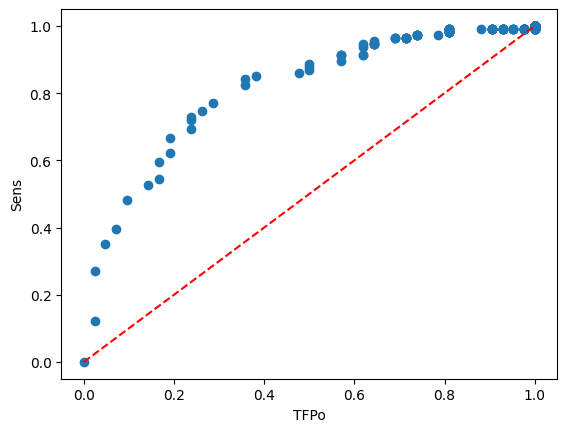

In [35]:
#Curva ROC

Sens = []
TFPo = []
Thresholds = np.logspace(-100, 0, num = 10000)

for Threshold in Thresholds:
    
    Label_Calc_ROC = np.empty((0,1))
    for Label_Calc_Bruto in Label_Calcs_Bruto:
        if Label_Calc_Bruto >= Threshold:
            Label_Calc_Bruto = 1
        else:
            Label_Calc_Bruto = 0
        Label_Calc_ROC = np.vstack((Label_Calc_ROC, Label_Calc_Bruto))
    #print(Label_Calc_ROC)

    TP = np.sum(np.equal(Label_Calc_ROC, 1) & np.equal(Test_Labels, 1))
    FP = np.sum(np.equal(Label_Calc_ROC, 1) & np.equal(Test_Labels, 0))
    FN = np.sum(np.equal(Label_Calc_ROC, 0) & np.equal(Test_Labels, 1))
    TN = np.sum(np.equal(Label_Calc_ROC, 0) & np.equal(Test_Labels, 0))
    
    #print(TP, FP, FN, TN)

    Sens.append(TP / (TP + FN)) 
    TFPo.append(FP / (FP + TN))
    
fig, ax = plt.subplots()
ax.scatter(TFPo, Sens)
ax.plot(np.linspace(0, 1, 6), np.linspace(0, 1, 6), '--', color = 'red')
ax.set_xlabel('TFPo')
ax.set_ylabel('Sens')
plt.show()

A curva ROC para o método de regressão logística não havia ficado muito clara antes de os dados serem normalizados. A função utilizada cravava os valores altos em um e baixos em zero, deixando pouca margem para a geração da curva. Contudo, após a normalização dos dados a curva conseguiu ser gerada de forma mais clara. Para diferentes limitantes, os valores de Sensibilidade e Taxa de Falso Positivo foram calculados. Percebe-se que o seu desempenho é de fato melhor que o classificador aleatório, caracterizado pela linha diagonal tracejada.

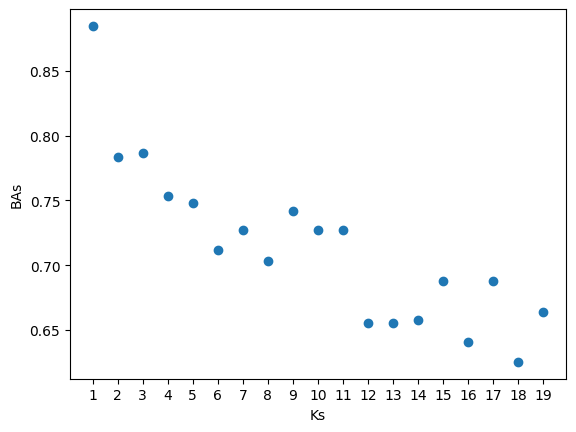

In [36]:
# Knn para a validação
 
def KNN(K, Fi_Set, Fi_Train):
    Label_Calcs_Bruto = np.empty((0,1))
    Label_Calcs = np.empty((0,1))
    for Novo_Padrao in Fi_Set[:, 1:len(Fi_Set[0])]:
        Distancias = np.empty((0, 2))
        for Padrao, Label in zip(Fi_Train[:, 1:len(Fi_Train[0])], Train_Labels):
            Distancia = [np.linalg.norm(Novo_Padrao - Padrao), Label[0]]
            Distancias = np.vstack((Distancias, Distancia))
        Distancias = np.sort(Distancias.view('f8, f8'), order=['f0'], axis=0)
        Distancias = Distancias[0:K]
        Distancias = Distancias.view(dtype = np.float64)
        Label_Calc = np.sum(Distancias, axis = 0)[1] / K
        Label_Calcs_Bruto = np.vstack((Label_Calcs_Bruto, Label_Calc))
        if Label_Calc >= .5:
            Label_Calc = 1
        else:
            Label_Calc = 0
        Label_Calcs = np.vstack((Label_Calcs, Label_Calc))
    return Label_Calcs, Label_Calcs_Bruto

Ks = []
BAs = []
for K in range(1, 20, 1):    
    
    Label_Calcs, Label_Calcs_Bruto = KNN(K, Fi_Val, Fi_Train)

    TP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Val_Labels, 1))
    FP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Val_Labels, 0))
    FN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Val_Labels, 1))
    TN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Val_Labels, 0))


    Matriz_Conf = np.array([[TP, FN], 
                            [FP, TN]])    

    Espe = TN / (TN + FP)
    Sens = TP / (TP + FN)
    Prec = TP / (TP + FP)
    TFPo = FP / (TN + FP)

    BA = (Espe + Sens) / 2
    Acc = (TP + TN) / (TP + TN + FP + FN)
    Fm = (2 * Sens * Prec) / (Sens + Prec)
    
    BAs.append(BA)
    Ks.append(K)

fig, ax = plt.subplots()
ax.scatter(Ks, BAs)
ax.set_xlabel('Ks')
ax.set_ylabel('BAs')
plt.locator_params ('x', nbins = 2*len(Ks))
plt.show()

        

A função KNN implementa o método KNN, *K-nearest neighbors* para um certo valor $K$ de vizinhos e para um conjunto alvo, utilizando o conjunto de treinamento como base para o cálculo das distâncias. A função calcula a distância euclidiana de uma novo dado do conjunto de validação aos dados do conjunto de treinamento e atribui o novo rótulo com base na média aritmética dos rótulos dos K dados mais próximos ao novo dado. O gráfico gerado mostra como a acurácia balanceada, obtida utilizando o método KNN para o conjunto de validação, varia conforme o aumento do parâmetro $K$. Essa métrica foi escolhida, pois ela é boa para analisar situações em que há desbalanço entre as classes, como é o caso. Sendo assim, o valor escolhido para a etapa de teste foi $K = 1$, que proporcionou o melhor valor de Acurácia Balanceada.

In [37]:
# Knn para o teste com K = 1
K = 1
Label_Calcs, Label_Calcs_Bruto = KNN(K, Fi_Test, Fi_Train)

TP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Test_Labels, 1))
FP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Test_Labels, 0))
FN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Test_Labels, 1))
TN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Test_Labels, 0))


Matriz_Conf = np.array([[TP, FN], 
                        [FP, TN]])    

Espe = TN / (TN + FP)
Sens = TP / (TP + FN)
Prec = TP / (TP + FP)
TFPo = FP / (TN + FP)

BA = (Espe + Sens) / 2
Acc = (TP + TN) / (TP + TN + FP + FN)
Fm = (2 * Sens * Prec) / (Sens + Prec)

print('BA: ', BA)
print('Acc: ', Acc)
print('Fm: ', Fm)



BA:  0.7337092731829574
Acc:  0.7756410256410257
Fm:  0.8430493273542601


Na etapa de teste com K = 1, as métricas de Acurácia Balanceada, Precisão e F-medida, foram calculadas:

- Acurácia Balanceada  = **0.73**
- Acurácia             = **0.77**
- F-medida             = **0.84**

Nota-se que o desempenho do modelo ficou tenuemente pior em termos de Acurácia Balanceada, mas mostrou uma melhora sutil na Acurácia e na F-medida, em comparação com os valores obtidos utilizando a regressão logística. A vantagem computacional deste método se dá por conta de que o modelo não precisar ser treinado e ter parâmetros ajustados.